In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

from joblib import Parallel, delayed

pd.set_option("display.max_columns", 101)

In [2]:
# Credit: The reduce_mem_usage function has been taken from 
# https://gist.github.com/tkazusa/4d9e26d403c73755edc6b77b5b053a43
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and str(col_type)!= 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
sales_train_validation_data = pd.read_csv('data/sales_train_validation.csv')
sales_train_validation_data = reduce_mem_usage(sales_train_validation_data)
calendar_data = pd.read_csv('data/calendar.csv')
calendar_data = reduce_mem_usage(calendar_data)
prices_data = pd.read_csv('data/sell_prices.csv')
prices_data = reduce_mem_usage(prices_data)

Memory usage of dataframe is 446.40 MB
Memory usage after optimization is: 95.42 MB
Decreased by 78.6%
Memory usage of dataframe is 0.21 MB
Memory usage after optimization is: 0.22 MB
Decreased by -5.7%
Memory usage of dataframe is 208.77 MB
Memory usage after optimization is: 45.77 MB
Decreased by 78.1%


In [5]:
# doing this to generate test data for 28 days (d_1914 to d_1941)
for i in range(1914, 1942):
    sales_train_validation_data['d_'+str(i)] = np.nan

In [7]:
sales_train_validation_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,...,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,1,0,...,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
d_colnames = []
# 1914 + 28 days for test
for i in range(1, 1942):
    d_colnames.append('d_'+str(i))
    
sales_train_validation_data_new = pd.melt(sales_train_validation_data, \
        id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
        value_vars=d_colnames, var_name='day_number', value_name='units_sold')
sales_train_validation_data_new['day_number'] = \
    sales_train_validation_data_new['day_number'].apply(lambda x: int(x[2:]))
sales_train_validation_data_new = reduce_mem_usage(sales_train_validation_data_new)
sales_train_validation_data_new

Memory usage of dataframe is 1356.13 MB
Memory usage after optimization is: 678.86 MB
Decreased by 49.9%


,id,item_id,dept_id,cat_id,store_id,state_id,day_number,units_sold
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0
5,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0
6,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0
7,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,1,12.0
8,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,1,2.0
9,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0


In [9]:
calendar_data['d'] = \
    calendar_data['d'].apply(lambda x: int(x[2:]))
merged_df = sales_train_validation_data_new.merge(calendar_data, left_on='day_number', right_on='d', how='left')
merged_df = reduce_mem_usage(merged_df)
del calendar_data
del sales_train_validation_data
del sales_train_validation_data_new
gc.collect() # Garbage collector

Memory usage of dataframe is 2485.11 MB
Memory usage after optimization is: 2146.57 MB
Decreased by 13.6%


1594

In [10]:
df = merged_df.merge(
    prices_data, left_on=['store_id', 'item_id', 'wm_yr_wk'],
    right_on=['store_id', 'item_id', 'wm_yr_wk'],
    how='left')
df = reduce_mem_usage(df)

Memory usage of dataframe is 2259.45 MB
Memory usage after optimization is: 2259.45 MB
Decreased by 0.0%


In [11]:
del merged_df
del prices_data
gc.collect()

89

In [12]:
df.drop(['wday', 'd', 'wm_yr_wk'], inplace=True, axis=1)
df['date'] = pd.to_datetime(df['date'])
df['week'] = df['date'].dt.week
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day_number,units_sold,date,weekday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,week
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,2011-01-29,Saturday,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,2011-01-29,Saturday,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,2011-01-29,Saturday,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,2011-01-29,Saturday,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,2011-01-29,Saturday,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4


In [13]:
df.to_pickle("./data.pkl")

In [3]:
# Testing if pickle (serializing) the dataframe to file has worked
unpickled_df = pd.read_pickle("./data.pkl")
unpickled_df

,id,item_id,dept_id,cat_id,store_id,state_id,day_number,units_sold,date,weekday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,week
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,2011-01-29,Saturday,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,2011-01-29,Saturday,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,2011-01-29,Saturday,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,2011-01-29,Saturday,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,2011-01-29,Saturday,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4
5,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,2011-01-29,Saturday,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4
6,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,2011-01-29,Saturday,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4
7,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,1,12.0,2011-01-29,Saturday,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.459961,4
8,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,1,2.0,2011-01-29,Saturday,1,2011,NaN,NaN,NaN,NaN,0,0,0,1.559570,4
9,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,2011-01-29,Saturday,1,2011,NaN,NaN,NaN,NaN,0,0,0,3.169922,4


In [4]:
# We assume that the first 1000 days of data will not be relevant to forecast future sales since 
# this data is very old
unpickled_df = unpickled_df[unpickled_df.day_number.astype(int) > 972]
len(unpickled_df)

29544810

In [5]:
# Check if both event_name_1 and event_name_2 are populated for any rows
unpickled_df[~unpickled_df.event_name_1.isnull() & ~unpickled_df.event_name_2.isnull()]

,id,item_id,dept_id,cat_id,store_id,state_id,day_number,units_sold,date,weekday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,week
35886730,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1178,0.0,2014-04-20,Sunday,4,2014,Easter,Cultural,OrthodoxEaster,Religious,0,0,0,8.257812,16
35886731,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1178,0.0,2014-04-20,Sunday,4,2014,Easter,Cultural,OrthodoxEaster,Religious,0,0,0,3.970703,16
35886732,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1178,0.0,2014-04-20,Sunday,4,2014,Easter,Cultural,OrthodoxEaster,Religious,0,0,0,2.970703,16
35886733,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1178,4.0,2014-04-20,Sunday,4,2014,Easter,Cultural,OrthodoxEaster,Religious,0,0,0,4.640625,16
35886734,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1178,3.0,2014-04-20,Sunday,4,2014,Easter,Cultural,OrthodoxEaster,Religious,0,0,0,3.080078,16
35886735,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,1178,0.0,2014-04-20,Sunday,4,2014,Easter,Cultural,OrthodoxEaster,Religious,0,0,0,1.000000,16
35886736,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,1178,0.0,2014-04-20,Sunday,4,2014,Easter,Cultural,OrthodoxEaster,Religious,0,0,0,7.878906,16
35886737,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,1178,3.0,2014-04-20,Sunday,4,2014,Easter,Cultural,OrthodoxEaster,Religious,0,0,0,0.459961,16
35886738,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,1178,4.0,2014-04-20,Sunday,4,2014,Easter,Cultural,OrthodoxEaster,Religious,0,0,0,1.769531,16
35886739,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,1178,0.0,2014-04-20,Sunday,4,2014,Easter,Cultural,OrthodoxEaster,Religious,0,0,0,2.970703,16


In [6]:
unique_item_ids = unpickled_df.item_id.unique().to_list()
print(len(unique_item_ids))
unique_item_ids

3049


['HOBBIES_1_001',
 'HOBBIES_1_002',
 'HOBBIES_1_003',
 'HOBBIES_1_004',
 'HOBBIES_1_005',
 'HOBBIES_1_006',
 'HOBBIES_1_007',
 'HOBBIES_1_008',
 'HOBBIES_1_009',
 'HOBBIES_1_010',
 'HOBBIES_1_011',
 'HOBBIES_1_012',
 'HOBBIES_1_013',
 'HOBBIES_1_014',
 'HOBBIES_1_015',
 'HOBBIES_1_016',
 'HOBBIES_1_017',
 'HOBBIES_1_018',
 'HOBBIES_1_019',
 'HOBBIES_1_020',
 'HOBBIES_1_021',
 'HOBBIES_1_022',
 'HOBBIES_1_023',
 'HOBBIES_1_024',
 'HOBBIES_1_025',
 'HOBBIES_1_026',
 'HOBBIES_1_027',
 'HOBBIES_1_028',
 'HOBBIES_1_029',
 'HOBBIES_1_030',
 'HOBBIES_1_031',
 'HOBBIES_1_032',
 'HOBBIES_1_033',
 'HOBBIES_1_034',
 'HOBBIES_1_035',
 'HOBBIES_1_036',
 'HOBBIES_1_037',
 'HOBBIES_1_038',
 'HOBBIES_1_039',
 'HOBBIES_1_040',
 'HOBBIES_1_041',
 'HOBBIES_1_042',
 'HOBBIES_1_043',
 'HOBBIES_1_044',
 'HOBBIES_1_045',
 'HOBBIES_1_046',
 'HOBBIES_1_047',
 'HOBBIES_1_048',
 'HOBBIES_1_049',
 'HOBBIES_1_050',
 'HOBBIES_1_051',
 'HOBBIES_1_052',
 'HOBBIES_1_053',
 'HOBBIES_1_054',
 'HOBBIES_1_055',
 'HOBBIES_

In [9]:
# We consolidate 3 snap columns into 1, as one row corresponds to one state only,
# so we don't really care about the corresponding state values for other states for that row
def snap(row):
    if row['snap_'+ row.state_id] == 1:
        return 1
    return 0

def product_feature_generation(itemid):
    product = unpickled_df.loc[unpickled_df.item_id == itemid].copy()
    product['snap'] = product.apply(snap, axis=1)
    product.drop(['snap_CA', 'snap_WI', 'snap_TX'], axis=1, inplace=True)
    # We can drop:
    # cat_id as dept_id already contains category name
    # state_id as store_id already contains state
    # day_number as it is just a number which will not be useful for modelling
    # date and year
    product.drop(['cat_id', 'state_id', 'date', 'year'], axis=1, inplace=True)
    product['units_lag_28'] = product.groupby('id')['units_sold'].transform(
        lambda x: x.shift(28, fill_value=0)
    )
    
    # https://pbpython.com/pandas_transform.html
    # Rolling units sold for days -28 to -34
    product['mean_rolling_7'] = product.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(7, min_periods=1).mean()
    )
    # Rolling units sold for days -28 to -55
    product['mean_rolling_28'] = product.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(28, min_periods=1).mean()
    )
    # Rolling units sold for days -28 to -76
    product['mean_rolling_49'] = product.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(49, min_periods=1).mean()
    )
    product['mean_rolling_84'] = product.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(84, min_periods=1).mean()
    )
    product['mean_rolling_140'] = product.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(140, min_periods=1).mean()
    )
    

    product['std_rolling_7'] = product.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(7, min_periods=1).std()
    )
    product['std_rolling_28'] = product.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(28, min_periods=1).std()
    )
    product['std_rolling_49'] = product.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(49, min_periods=1).std()
    )
    product['std_rolling_84'] = product.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(84, min_periods=1).std()
    )
    product['std_rolling_140'] = product.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(140, min_periods=1).std()
    )
    
    product['std_price_rolling_7'] = product.groupby('id')['sell_price'].transform(
        lambda x: x.rolling(7, min_periods=1).std()
    )
    product['std_price_rolling_28'] = product.groupby('id')['sell_price'].transform(
        lambda x: x.rolling(28, min_periods=1).std()
    )
    product['price_percent_change'] = product.groupby('id')['sell_price'].pct_change()
    
    product.drop(['id', 'item_id', 'event_name_1', 'event_name_2', 'week'], axis=1, inplace=True)
    
    categorical_cols = ['weekday', 'month']
    for col in categorical_cols:
        product[col] = product[col].astype('category')
    product.reset_index(drop=True, inplace=True)
    
    encoded_cols = pd.get_dummies(product[[
        'dept_id', 'store_id', 'weekday', 'month', 'event_type_1', 'event_type_2'
    ]]).reset_index(drop=True)
    product.drop(['dept_id', 'weekday', 'month', 'event_type_1', 'event_type_2'], axis=1, inplace=True)
    product = pd.concat([product, encoded_cols], axis=1)
    
    # Keep only non-zero rolling value rows
    product = product[product.day_number.astype(int) > 1000]
    
    return product

In [10]:
first_product = product_feature_generation('HOBBIES_1_001')
#first_product.to_pickle("HOBBIES_1_001_feature.pkl")
first_product

,store_id,day_number,units_sold,sell_price,snap,units_lag_28,mean_rolling_7,mean_rolling_28,mean_rolling_49,mean_rolling_84,mean_rolling_140,std_rolling_7,std_rolling_28,std_rolling_49,std_rolling_84,std_rolling_140,std_price_rolling_7,std_price_rolling_28,price_percent_change,dept_id_FOODS_1,dept_id_FOODS_2,dept_id_FOODS_3,dept_id_HOBBIES_1,dept_id_HOBBIES_2,dept_id_HOUSEHOLD_1,dept_id_HOUSEHOLD_2,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural,event_type_2_Religious
280,CA_1,1001,2.0,8.257812,0,1.0,0.142822,0.035706,0.034485,0.034485,0.034485,0.377930,0.188965,0.185669,0.185669,0.185669,0.000000e+00,0.0,0.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
281,CA_2,1001,0.0,8.257812,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
282,CA_3,1001,2.0,8.257812,0,1.0,0.142822,0.035706,0.034485,0.034485,0.034485,0.377930,0.188965,0.185669,0.185669,0.185669,0.000000e+00,0.0,0.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
283,CA_4,1001,0.0,8.257812,0,2.0,0.285645,0.071411,0.068970,0.068970,0.068970,0.755859,0.377930,0.371338,0.371338,0.371338,0.000000e+00,0.0,0.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
284,TX_1,1001,0.0,8.257812,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
285,TX_2,1001,1.0,8.257812,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
286,TX_3,1001,0.0,8.617188,0,1.0,0.142822,0.035706,0.034485,0.034485,0.034485,0.377930,0.188965,0.185669,0.185669,0.185669,0.000000e+00,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
287,WI_1,1001,0.0,8.257812,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
288,WI_2,1001,0.0,8.617188,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
289,WI_3,1001,0.0,8.257812,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [19]:
import multiprocessing
print(multiprocessing.cpu_count())

6


In [21]:
# This is just a test, we will need this later to generate features for all products
import time
start = time.time()
feature_data = Parallel(n_jobs=6, verbose=10)\
    (delayed(product_feature_generation)(item_id) for item_id in unique_item_ids[:40])
print(time.time()- start)

for item_id, data in zip(unique_item_ids[:40], feature_data):
    data.to_pickle(f"./{item_id}_feature.pkl")


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   56.4s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   57.4s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done  34 out of  40 | elapsed:  5.6min remaining:   59.8s


392.7362771034241


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:  6.5min finished


## Divide into training and validation set

In [11]:
# Time series split so we cannot shuffle
first_product_train = first_product[first_product.day_number.astype(int) <= 1885].reset_index(drop=True) # 1913-28
first_product_validation = first_product[(first_product.day_number.astype(int) > 1885)
                                         & (first_product.day_number.astype(int) < 1914)].reset_index(drop=True)
first_product_test = first_product[first_product.day_number.astype(int) >= 1914].reset_index(drop=True)

In [13]:
first_product_test.head()

,store_id,day_number,units_sold,sell_price,snap,units_lag_28,mean_rolling_7,mean_rolling_28,mean_rolling_49,mean_rolling_84,mean_rolling_140,std_rolling_7,std_rolling_28,std_rolling_49,std_rolling_84,std_rolling_140,std_price_rolling_7,std_price_rolling_28,price_percent_change,dept_id_FOODS_1,dept_id_FOODS_2,dept_id_FOODS_3,dept_id_HOBBIES_1,dept_id_HOBBIES_2,dept_id_HOUSEHOLD_1,dept_id_HOUSEHOLD_2,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural,event_type_2_Religious
0,CA_1,1914,NaN,8.382812,0,1.0,1.142578,1.036133,1.061523,0.940430,0.842773,0.689941,0.922363,1.143555,1.144531,1.047852,0.0,0.062164,0.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CA_2,1914,NaN,8.382812,0,0.0,0.714355,0.856934,0.734863,0.714355,0.700195,1.112305,0.848145,0.810547,0.829590,0.862305,0.0,0.062164,0.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CA_3,1914,NaN,8.382812,0,2.0,2.000000,1.213867,1.061523,0.976074,0.914062,1.915039,1.197266,1.179688,1.298828,1.266602,0.0,0.062164,0.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,CA_4,1914,NaN,8.382812,0,2.0,1.142578,0.964355,0.958984,0.880859,0.850098,1.214844,1.036133,1.019531,0.974609,0.974121,0.0,0.062164,0.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,TX_1,1914,NaN,8.257812,0,1.0,0.428467,0.392822,0.306152,0.250000,0.242798,0.534668,0.497314,0.465576,0.487793,0.492676,0.0,0.000000,0.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
first_product_validation.head()

,store_id,day_number,units_sold,sell_price,snap,units_lag_28,mean_rolling_7,mean_rolling_28,mean_rolling_49,mean_rolling_84,mean_rolling_140,std_rolling_7,std_rolling_28,std_rolling_49,std_rolling_84,std_rolling_140,std_price_rolling_7,std_price_rolling_28,price_percent_change,dept_id_FOODS_1,dept_id_FOODS_2,dept_id_FOODS_3,dept_id_HOBBIES_1,dept_id_HOBBIES_2,dept_id_HOUSEHOLD_1,dept_id_HOUSEHOLD_2,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural,event_type_2_Religious
0,CA_1,1886,1.0,8.257812,0,0.0,1.142578,1.000000,0.897949,0.869141,0.728516,1.463867,1.276367,1.228516,1.159180,1.031250,0.0,0.0,0.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CA_2,1886,0.0,8.257812,0,0.0,0.714355,0.643066,0.652832,0.571289,0.649902,0.755859,0.869629,0.830566,0.765137,0.913086,0.0,0.0,0.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CA_3,1886,2.0,8.257812,0,0.0,0.571289,0.928711,0.734863,0.797852,0.835938,0.786621,1.120117,1.036133,1.209961,1.203125,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,CA_4,1886,2.0,8.257812,0,2.0,1.000000,0.856934,0.836914,0.845215,0.807129,0.816406,0.931641,0.986328,0.950684,0.928223,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,TX_1,1886,1.0,8.257812,0,0.0,0.285645,0.214233,0.204102,0.214233,0.221436,0.488037,0.498779,0.499268,0.492676,0.495605,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
first_product_train.head()

,store_id,day_number,units_sold,sell_price,snap,units_lag_28,mean_rolling_7,mean_rolling_28,mean_rolling_49,mean_rolling_84,mean_rolling_140,std_rolling_7,std_rolling_28,std_rolling_49,std_rolling_84,std_rolling_140,std_price_rolling_7,std_price_rolling_28,price_percent_change,dept_id_FOODS_1,dept_id_FOODS_2,dept_id_FOODS_3,dept_id_HOBBIES_1,dept_id_HOBBIES_2,dept_id_HOUSEHOLD_1,dept_id_HOUSEHOLD_2,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural,event_type_2_Religious
0,CA_1,1001,2.0,8.257812,0,1.0,0.142822,0.035706,0.034485,0.034485,0.034485,0.377930,0.188965,0.185669,0.185669,0.185669,0.0,0.0,0.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,CA_2,1001,0.0,8.257812,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,CA_3,1001,2.0,8.257812,0,1.0,0.142822,0.035706,0.034485,0.034485,0.034485,0.377930,0.188965,0.185669,0.185669,0.185669,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,CA_4,1001,0.0,8.257812,0,2.0,0.285645,0.071411,0.068970,0.068970,0.068970,0.755859,0.377930,0.371338,0.371338,0.371338,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,TX_1,1001,0.0,8.257812,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [16]:
first_product_train_x = first_product_train.iloc[:, 3:]
first_product_train_y = first_product_train.units_sold
first_product_validation_x = first_product_validation.iloc[:, 3:]
first_product_validation_y = first_product_validation.units_sold

first_product_test_x = first_product_test.iloc[:, 3:]

In [17]:
first_product_train_x.head()

,sell_price,snap,units_lag_28,mean_rolling_7,mean_rolling_28,mean_rolling_49,mean_rolling_84,mean_rolling_140,std_rolling_7,std_rolling_28,std_rolling_49,std_rolling_84,std_rolling_140,std_price_rolling_7,std_price_rolling_28,price_percent_change,dept_id_FOODS_1,dept_id_FOODS_2,dept_id_FOODS_3,dept_id_HOBBIES_1,dept_id_HOBBIES_2,dept_id_HOUSEHOLD_1,dept_id_HOUSEHOLD_2,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural,event_type_2_Religious
0,8.257812,0,1.0,0.142822,0.035706,0.034485,0.034485,0.034485,0.377930,0.188965,0.185669,0.185669,0.185669,0.0,0.0,0.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,8.257812,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,8.257812,0,1.0,0.142822,0.035706,0.034485,0.034485,0.034485,0.377930,0.188965,0.185669,0.185669,0.185669,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,8.257812,0,2.0,0.285645,0.071411,0.068970,0.068970,0.068970,0.755859,0.377930,0.371338,0.371338,0.371338,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,8.257812,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [18]:
first_product_train_y.head()

0    2.0
1    0.0
2    2.0
3    0.0
4    0.0
Name: units_sold, dtype: float16

## Calculate feature importances + try a simple random forest

In [19]:
regr = RandomForestRegressor(random_state=0)
regr.fit(first_product_train_x, first_product_train_y)

/home/asif/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [20]:
sorted_feature_importance_indices = np.argsort(regr.feature_importances_)[::-1]
print(sorted_feature_importance_indices)

[ 7 12 11 10  9  6  5  8  4  3  2 35 38 39 36 34 37 33  1 53 51 41 23 50
 46 24 25 42 54 44 40 45 26 43 49 47 48 28 30 52 29  0 32 31 27 14 55 13
 57 15 56 16 17 18 19 20 21 22]


In [21]:
feature_cols = first_product_train_x.columns.to_list()
feature_cols

['sell_price',
 'snap',
 'units_lag_28',
 'mean_rolling_7',
 'mean_rolling_28',
 'mean_rolling_49',
 'mean_rolling_84',
 'mean_rolling_140',
 'std_rolling_7',
 'std_rolling_28',
 'std_rolling_49',
 'std_rolling_84',
 'std_rolling_140',
 'std_price_rolling_7',
 'std_price_rolling_28',
 'price_percent_change',
 'dept_id_FOODS_1',
 'dept_id_FOODS_2',
 'dept_id_FOODS_3',
 'dept_id_HOBBIES_1',
 'dept_id_HOBBIES_2',
 'dept_id_HOUSEHOLD_1',
 'dept_id_HOUSEHOLD_2',
 'store_id_CA_1',
 'store_id_CA_2',
 'store_id_CA_3',
 'store_id_CA_4',
 'store_id_TX_1',
 'store_id_TX_2',
 'store_id_TX_3',
 'store_id_WI_1',
 'store_id_WI_2',
 'store_id_WI_3',
 'weekday_Friday',
 'weekday_Monday',
 'weekday_Saturday',
 'weekday_Sunday',
 'weekday_Thursday',
 'weekday_Tuesday',
 'weekday_Wednesday',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'event_type_1_Cultural',
 'event_type_1_National',
 'event_type_1_Rel

In [23]:
ordered_feature_importances = [feature_cols[i] for i in sorted_feature_importance_indices]
ordered_feature_importances

['mean_rolling_140',
 'std_rolling_140',
 'std_rolling_84',
 'std_rolling_49',
 'std_rolling_28',
 'mean_rolling_84',
 'mean_rolling_49',
 'std_rolling_7',
 'mean_rolling_28',
 'mean_rolling_7',
 'units_lag_28',
 'weekday_Saturday',
 'weekday_Tuesday',
 'weekday_Wednesday',
 'weekday_Sunday',
 'weekday_Monday',
 'weekday_Thursday',
 'weekday_Friday',
 'snap',
 'event_type_1_National',
 'month_12',
 'month_2',
 'store_id_CA_1',
 'month_11',
 'month_7',
 'store_id_CA_2',
 'store_id_CA_3',
 'month_3',
 'event_type_1_Religious',
 'month_5',
 'month_1',
 'month_6',
 'store_id_CA_4',
 'month_4',
 'month_10',
 'month_8',
 'month_9',
 'store_id_TX_2',
 'store_id_WI_1',
 'event_type_1_Cultural',
 'store_id_TX_3',
 'sell_price',
 'store_id_WI_3',
 'store_id_WI_2',
 'store_id_TX_1',
 'std_price_rolling_28',
 'event_type_1_Sporting',
 'std_price_rolling_7',
 'event_type_2_Religious',
 'price_percent_change',
 'event_type_2_Cultural',
 'dept_id_FOODS_1',
 'dept_id_FOODS_2',
 'dept_id_FOODS_3',
 'de

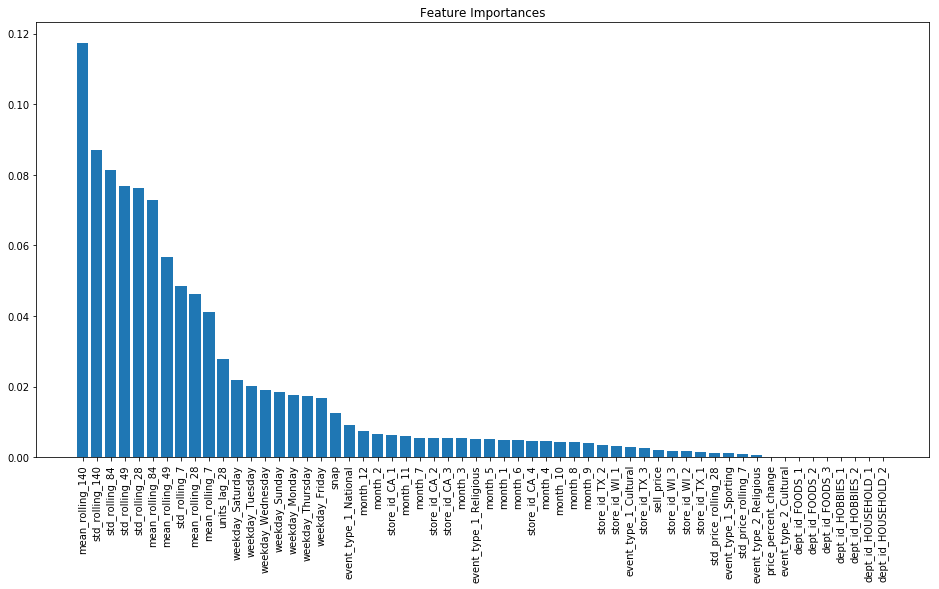

In [24]:
plt.figure(figsize=(16,8))
plt.title("Feature Importances")
plt.bar(range(first_product_train_x.shape[1]), regr.feature_importances_[sorted_feature_importance_indices])
plt.xticks(range(first_product_train_x.shape[1]), ordered_feature_importances, rotation=90)
plt.show()

In [25]:
preds = np.round(regr.predict(first_product_validation_x))
preds

array([1., 1., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0.,
       1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 2., 0., 0., 0., 0., 1.,
       2., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1.,
       0., 0., 0., 1., 2., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0.,
       1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       1., 2., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
       1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 1.

In [26]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(first_product_validation_y.values, preds))

0.9505637425083225

In [50]:
np.average(first_product_validation_y.values)

0.518

In [51]:
preds.shape

(280,)

In [52]:
first_product_validation_x.shape

(280, 49)

In [55]:
# Predictions on test set for this product
test_preds = np.round(regr.predict(first_product_test_x))
test_preds

array([1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 2., 1., 0., 0., 1.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 2.,
       1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
       0., 1., 0., 0., 0., 1., 2., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 2., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 1., 2., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 1.